run this on google collab

In [1]:
# general imports
import yfinance as yf
import pandas as pd

In [11]:
# pytorch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import os
import math
import itertools
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

# ml related
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm


## Data


### Loading in Data

In [12]:
# YFINANCE
# create a ticker object, then get history
btc_tk = yf.Ticker("BTC-USD")
btc_all_data_raw = btc_tk.history(period="max")

btc_f_tk = yf.Ticker("BTC=F") # unused
btc_futures_all_data = btc_f_tk.history(period="max")

vix_tk = yf.Ticker("^VIX") # unused
vix_all_data = vix_tk.history(period="max")

btc_hourly = pd.read_csv("kaggle_btc_hourly.csv")

In [4]:
# 2020-01-02 to 2022-02-28
btc_hourly.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [5]:
# # one time code
# btc_tweets_large = pd.read_csv("Bitcoin_tweets.csv", engine='python')
# btc_tweets_small = btc_tweets_large[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_small.to_pickle('btc_tweets_small.pkl')

# btc_tweets_smallest = pd.read_csv("Bitcoin_tweets_dataset_2.csv", engine='python')
# btc_tweets_smallest = btc_tweets_smallest[["user_followers", "user_verified", "date", "text", "hashtags", "source", "is_retweet"]]
# btc_tweets_smallest.to_pickle('btc_tweets_smallest.pkl')

# btc_tweets_smallest.to_pickle('~/btc_tweets_smallest.pkl')

In [6]:
# Fear and greed data - unused in final version, attempted training model with this combined with prices
# mkt_sentiment = pd.read_csv("btc_fearandgreed.csv")
# mkt_sentiment.set_index('Date', inplace=True)
# mkt_sentiment.tail()

### Cleaning Data

In [13]:
def clean_data(data, start="2020-01-01", end="2023-03-31"):
    # # set Date to index if not already
    # data.set_index('Date', inplace=True)

    # filter with and start and end
    if start:
        data = data[data.index >= start]
    if end:
        data = data[data.index <= end]

    # check number of NA rows
    print(f"{data.isna().any(axis=1).sum()} / {len(data)} has NA in the row" )

    return data

In [8]:
# btc_all_data = clean_data(btc_all_data_raw)
# vix_all_data =  clean_data(vix_all_data)
# mkt_sentiment =  clean_data(mkt_sentiment)

In [9]:
# mkt_sentiment.head()

### CNN-LSTM Model



* still use entire dataset for training - scattering training and testing across time might mess with the model picking up patterns
* have dataset split by day for making trade decision / computing returns

#### Setting up data for model inputs
* tried a multi input CNN LSTM with a sentiment dataset (fear and greed), made the model worse



In [14]:
btc_hourly = btc_hourly.sort_values(by=['unix'], ascending=True)
btc_hourly.head()
btc_hourly["day"] = pd.to_datetime(btc_hourly['date']).dt.date
btc_hourly = btc_hourly[btc_hourly['day'] > pd.to_datetime('2020-01-01').date()] # restrict to after 2020
btc_hourly.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,day
18936,1577923200,2020-01-02 00:00:00,BTC/USD,7178.68,7184.94,7163.01,7184.86,119595.30,16.67,2020-01-02
18935,1577926800,2020-01-02 01:00:00,BTC/USD,7184.86,7184.86,7158.10,7163.27,280024.20,39.07,2020-01-02
18934,1577930400,2020-01-02 02:00:00,BTC/USD,7163.27,7166.01,7125.00,7142.87,1007304.71,141.08,2020-01-02
18933,1577934000,2020-01-02 03:00:00,BTC/USD,7142.87,7142.87,7092.70,7103.23,1951984.84,274.40,2020-01-02
18932,1577937600,2020-01-02 04:00:00,BTC/USD,7103.23,7133.34,7080.00,7113.65,866797.82,121.96,2020-01-02


In [15]:
# https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

all_data = btc_hourly[["unix", "open", "high", "low", "close", "Volume BTC", "date"]]
# all_data = btc_all_data[["Open", "High", "Low", "Close", "Volume"]] # daily data - date is the index
all_data.columns = all_data.columns.str.lower()


# exclude a part for use in sentiment analysis
start_date = pd.to_datetime('2021-02-05')
end_date = pd.to_datetime('2021-03-05')
# Filter out the date range you want to exclude
all_data = all_data[~((pd.to_datetime(all_data['date']) >= start_date) & (pd.to_datetime(all_data['date']) <= end_date))]

# 2021-02-05 - 2021-03-05



# same some for validation
# 30 days?
reserve_idxs = 30 * 24
all_data = all_data.iloc[:-reserve_idxs]

training_col = "close"

# split into training and testing data (no validaon set)
training_data_len = math.ceil(len(all_data) * .8)
train_data = all_data[:training_data_len].iloc[:, :]
test_data = all_data[training_data_len:].iloc[:, :]

print(f"train data range: {train_data['date'].iloc[0]} {train_data['date'].iloc[-1]}")
print(f"test data range: {test_data['date'].iloc[0]} {test_data['date'].iloc[-1]}")

# set up training dataset
dataset_train = train_data[training_col].values
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

# set up testing dataset
dataset_test = test_data[training_col].values
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

# normalizing values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
# print(scaled_train[:5])
scaled_test = scaler.fit_transform(dataset_test)
# print(scaled_test[:5])

sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# create sequences and labels for testing data
sequence_length = 30  # number of time steps to look back. ... do these need to be the same length
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

# convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

train data range: 2020-01-02 00:00:00 2021-09-05 20:00:00
test data range: 2021-09-05 21:00:00 2022-01-30 00:00:00
(14036, 1)
(3508, 1)
torch.Size([13986, 50, 1]) torch.Size([13986, 1])
torch.Size([3478, 30, 1]) torch.Size([3478, 1])


In [ ]:
train_data.head()

,unix,open,high,low,close,volume btc,date
18936,1577923200,7178.68,7184.94,7163.01,7184.86,119595.30,2020-01-02 00:00:00
18935,1577926800,7184.86,7184.86,7158.10,7163.27,280024.20,2020-01-02 01:00:00
18934,1577930400,7163.27,7166.01,7125.00,7142.87,1007304.71,2020-01-02 02:00:00
18933,1577934000,7142.87,7142.87,7092.70,7103.23,1951984.84,2020-01-02 03:00:00
18932,1577937600,7103.23,7133.34,7080.00,7113.65,866797.82,2020-01-02 04:00:00


In [ ]:
# # Fear & Greed Data Preparation
# fear_greed_df = mkt_sentiment[['Value']]  # Assuming 'value' is the column name

# # Split into training and testing data
# training_data_len_fg = math.ceil(len(fear_greed_df) * 0.8)
# train_data_fg = fear_greed_df[:training_data_len_fg]
# test_data_fg = fear_greed_df[training_data_len_fg:]

# # convert training and testing data to numpy arrays and reshape
# dataset_train_fg = train_data_fg['Value'].values
# dataset_train_fg = np.reshape(dataset_train_fg, (-1, 1))
# dataset_test_fg = test_data_fg['Value'].values
# dataset_test_fg = np.reshape(dataset_test_fg, (-1, 1))

# # normalize
# scaler_fg = MinMaxScaler(feature_range=(0, 1))
# scaled_train_fg = scaler_fg.fit_transform(dataset_train_fg)
# scaled_test_fg = scaler_fg.transform(dataset_test_fg)

# # create sequences for training and testing data
# sequence_length = 50  # Same length as used for the price data
# X_train_fg, y_train_fg = [], []
# for i in range(len(scaled_train_fg) - sequence_length):
#     X_train_fg.append(scaled_train_fg[i:i + sequence_length])
#     y_train_fg.append(scaled_train_fg[i + sequence_length])  # Predicting the value after the sequence
# X_train_fg, y_train_fg = np.array(X_train_fg), np.array(y_train_fg)

# X_test_fg, y_test_fg = [], []
# for i in range(len(scaled_test_fg) - sequence_length):
#     X_test_fg.append(scaled_test_fg[i:i + sequence_length])
#     y_test_fg.append(scaled_test_fg[i + sequence_length])
# X_test_fg, y_test_fg = np.array(X_test_fg), np.array(y_test_fg)

# # Convert data to PyTorch tensors
# X_train_fg = torch.tensor(X_train_fg, dtype=torch.float32)
# y_train_fg = torch.tensor(y_train_fg, dtype=torch.float32)
# X_test_fg = torch.tensor(X_test_fg, dtype=torch.float32)
# y_test_fg = torch.tensor(y_test_fg, dtype=torch.float32)

# # Print shapes to verify
# print("Fear & Greed X_train_fg:", X_train_fg.shape, "y_train_fg:", y_train_fg.shape)
# print("Fear & Greed X_test_fg:", X_test_fg.shape, "y_test_fg:", y_test_fg.shape)

### Architecture

Follow a CNN-LSTM approach

Model Architecture
  1. CNN
  2. Max pooling
  3. LSTM
  4. Dropout
  5. LSTM
  6. Dropout
  7. Dense

In [16]:
class BTCPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers, dropout_rate=0.2):
        super(BTCPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        # Adjust CNN to handle `n_features` input channels (e.g., 5 for OHLCV data)
        self.c1 = nn.Conv1d(in_channels=n_features, out_channels=n_features, kernel_size=2, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        # LSTM layers with `input_size=n_features`
        self.lstm1 = nn.LSTM(
            input_size=n_features,  # Match number of features in each time step
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(
            input_size=n_hidden,  # Output from LSTM 1 feeds to LSTM 2
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.dropout2 = nn.Dropout(dropout_rate)

        # Final linear layers
        self.linear1 = nn.Linear(in_features=n_hidden, out_features=1)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=1)

    def forward(self, sequences):
        # Expecting `sequences` to be (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = sequences.size()

        # Permute to match Conv1D expected input: (batch_size, n_features, seq_len)
        x = sequences.permute(0, 2, 1)
        x = self.c1(x)  # Apply Conv1D; shape becomes (batch_size, n_features, new_seq_len)
        x = self.maxpool(x)  # Apply MaxPool; shape becomes (batch_size, n_features, pooled_seq_len)

        # Permute to match LSTM expected input: (pooled_seq_len, batch_size, n_features)
        x = x.permute(2, 0, 1)

        # Initialize hidden state with dynamic batch size
        device = x.device
        hidden = (
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device),
            torch.zeros(self.n_layers, batch_size, self.n_hidden, device=device)
        )

        # Pass through LSTM layers
        lstm_out1, _ = self.lstm1(x, hidden)
        lstm_out1 = self.dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)

        # Use the last time step's output for prediction
        last_time_step = lstm_out2[-1, :, :]

        # Linear layers for final prediction
        y_pred = self.linear1(last_time_step)

        return y_pred


#### Model Training Cell below - no need to run

In [ ]:
# Model training - do on GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2  #  dropout for regularization, 20%

model = BTCPredictor(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

batch_size = 24  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

cuda
Epoch [10/50] - Training Loss: 0.0005, Test Loss: 0.0007
Epoch [20/50] - Training Loss: 0.0004, Test Loss: 0.0007
Epoch [30/50] - Training Loss: 0.0003, Test Loss: 0.0004
Epoch [40/50] - Training Loss: 0.0003, Test Loss: 0.0005
Epoch [50/50] - Training Loss: 0.0003, Test Loss: 0.0004


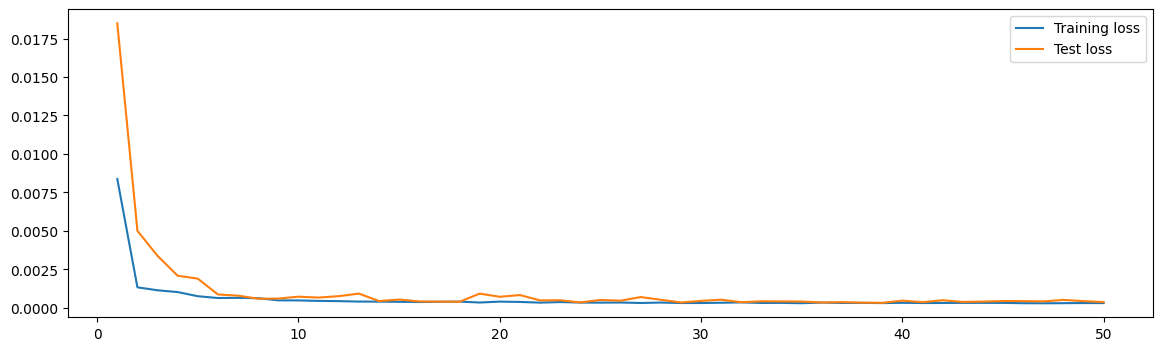

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [ ]:
last_test_date = test_data.loc[test_data.index[0], 'date']
last_test_date

'2021-09-05 21:00:00'

#### Model Inferencing - load in model, can run with CPU

In [18]:
# load in a model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2  #  dropout for regularization, 20%

model = BTCPredictor(input_size, hidden_size, num_layers, dropout).to(device)
model.load_state_dict(torch.load("model_hourly_close_excludes202102.pt",  map_location=torch.device('cpu')))
model.eval()

<ipython-input-18-7ab0c3dc1d2e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_hourly_close_excludes202102.pt",  map_location=torc

BTCPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(1, 128, num_layers=3)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 128, num_layers=3)
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=128, out_features=1, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

#### Prediction period: end of test set

In [28]:
# prediction based off of test dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prediction period in hours (adjusted from days for hourly data)
prediction_period_days = 1  # Number of days
num_forecast_steps = prediction_period_days * 24  # Convert to hours

# prepare historical data for prediction
sequence_to_plot = X_test.squeeze().cpu().numpy()  # Uses testing dataset?
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare historical data as input to the model
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)

        # Shift historical data for the next prediction
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

forecasted_values_rescaled = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

last_date = pd.to_datetime(test_data.loc[test_data.index[0], 'date']) # 0 for the latest date
future_dates = pd.date_range(start=last_date + pd.DateOffset(hours=1), periods=num_forecast_steps, freq='h')
# print(future_dates)

# Create DataFrame for forecasted values with corresponding dates
predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Value': forecasted_values_rescaled,
})

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')


RMSE: 0.0205
R² Score: 0.9921


In [29]:
# plt.rcParams['figure.figsize'] = [14, 4]
# predicted_df['Value'].plot()

In [30]:
# predicted_df.head()
# first_date = predicted_df['Date'].min()
# last_date = predicted_df['Date'].max()
# print(f"{first_date}, {last_date}")

# # from the original data
# actual_data = btc_hourly[(btc_hourly['date'] >= str(first_date)) & (btc_hourly['date'] <= str(last_date))]
# actual_data = actual_data.set_index("date")
# actual_data['close'].plot()


In [23]:
reserved_data = all_data.iloc[-reserve_idxs:]
reserved_data.tail()

,unix,open,high,low,close,volume btc,date
724,1643486400,37882.20,38698.52,37847.08,38382.44,179.505538,2022-01-29 20:00:00
723,1643490000,38375.12,38741.67,38313.96,38390.65,58.315624,2022-01-29 21:00:00
722,1643493600,38418.50,38438.71,38054.69,38170.67,58.224885,2022-01-29 22:00:00
721,1643497200,38159.26,38217.07,37939.02,38192.65,71.051738,2022-01-29 23:00:00
720,1643500800,38176.45,38288.88,37765.79,37862.59,46.641903,2022-01-30 00:00:00


#### Prediction period: 2022 01 (reserved end of dataset that the model hasn't seen)

In [24]:
# try prediction for a different date

# prediction in unseen data
def data_to_tensor(data, predict_col="close", sequence_length = 30):
  # convert dataframe to tensors

  """
  sequence_length: num of steps to look back
  """

  dataset_predict = data[predict_col].values
  dataset_predict = np.reshape(dataset_predict, (-1, 1))

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_predict = scaler.fit_transform(dataset_predict)

  X_predict, y_predict = [], []
  for i in range(len(scaled_predict) - sequence_length):
      X_predict.append(scaled_predict[i:i + sequence_length])
      y_predict.append(scaled_predict[i + sequence_length])  # Predicting the value right after the sequence
  X_predict, y_predict = np.array(X_predict), np.array(y_predict)

  # convert data to PyTorch tensors
  X_predict = torch.tensor(X_predict, dtype=torch.float32)
  y_predict = torch.tensor(y_predict, dtype=torch.float32)
  # print(X_predict.shape, y_predict.shape)

  return X_predict, y_predict


def predict_hourly(X_predict, data, predict_period_days=1):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Prediction period in hours (adjusted from days for hourly data)
  # prediction_period_days = 1  # Number of days
  num_forecast_steps = prediction_period_days * 24  # Convert to hours

  # prepare historical data for prediction
  sequence_to_plot = X_predict.squeeze().cpu().numpy()  # Uses testing dataset?
  historical_data = sequence_to_plot[-1]

  # prepare historical data for prediction
  sequence_to_plot = X_predict.squeeze().cpu().numpy()  # Uses testing dataset?
  historical_data = sequence_to_plot[-1]

  forecasted_values = []
  with torch.no_grad():
      for _ in range(num_forecast_steps):
          # Prepare historical data as input to the model
          historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
          predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
          forecasted_values.append(predicted_value)

          # Shift historical data for the next prediction
          historical_data = np.roll(historical_data, shift=-1)
          historical_data[-1] = predicted_value

  forecasted_values_rescaled = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

  # confirmed last date is pulled correctly
  last_date = pd.to_datetime(data.loc[data.index[-1], 'date']) # 0 for the latest date
  print(f"predicting from this date: {last_date}")
  future_dates = pd.date_range(start=last_date + pd.DateOffset(hours=1), periods=num_forecast_steps, freq='h')

  # df for forecasted values with corresponding dates
  predicted_df = pd.DataFrame({
      'Date': future_dates,
      'Value': forecasted_values_rescaled,
  })
  return predicted_df


In [25]:
x_tensors, y_tensors = data_to_tensor(reserved_data)
test2 = predict_hourly(x_tensors, reserved_data)
# test2

predicting from this date: 2022-01-30 00:00:00


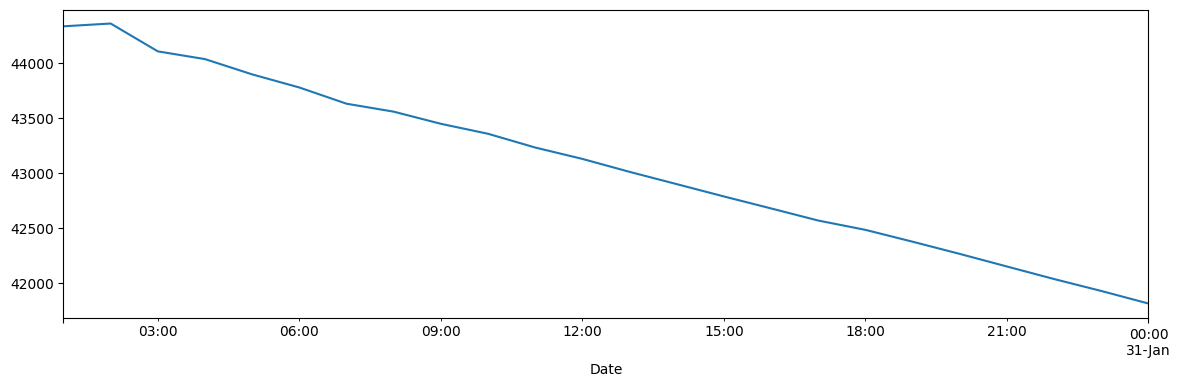

In [26]:
def plot_predicted(data):
  if "Date" in data.columns:
    data = data.set_index("Date")
  data['Value'].plot()

plot_predicted(test2)

2022-01-30 01:00:00, 2022-01-31 00:00:00


<Axes: xlabel='date'>

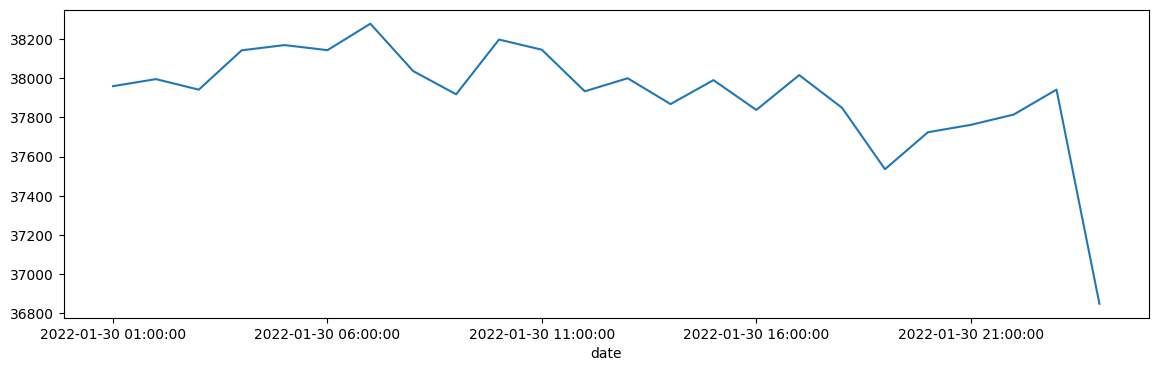

In [27]:
predicted = test2

first_date = predicted['Date'].min()
last_date = predicted['Date'].max()
print(f"{first_date}, {last_date}")

actual_data = btc_hourly[(btc_hourly['date'] >= str(first_date)) & (btc_hourly['date'] <= str(last_date))]
actual_data = actual_data.set_index("date")
actual_data['close'].plot()


In [32]:
def daily_trade_return(predicted_data, actual_data, window=3, fees=0.0002, sentiment_decision=None):
  # 0.2% fees

  # get average of first few hours and last few hours
  predicted_data = predicted_data.values
  actual_data = actual_data.values

  begin = np.mean(predicted_data[0:3])
  end = np.mean(predicted_data[-3:])
  if sentiment_decision is not None:
    initial_decision = sentiment_decision["initial"]
    hourly_decisions = sentiment_decision["detailed"]

  short_return = 0
  long_return = 0
  type_of_trade = "no action"

  # sentiment decision consideration - if doesn't match price prediction, don't take action
  if begin > end:
    if (sentiment_decision is None or initial_decision == "short"):
      # no conflict short!
      type_of_trade = "short"
      sell_price = actual_data[1]
      buy_price = actual_data[-1]
      short_return = (sell_price - buy_price) / buy_price
      return short_return - fees, type_of_trade
    else:
      # # code if nothing
      # return 0, "no action"

      # code if action
      # price model show short, but favorable sentiment
      type_of_trade = "dynamic: short whole day;"
      sell_price = actual_data[1]
      short_return = (actual_data[1] - actual_data[-1]) / actual_data[-1] - fees
      count_long, count_short = 0, 0
      # buy_price = None
      buy_price, sell_price = None, None
      for i in range(0, 24):
        if hourly_decisions[i] == "long":
          count_long += 1
          count_short = 0
        elif hourly_decisions[i] == "short":
          count_short += 1
          count_long = 0

        if count_long > 3 and buy_price is None:
          buy_price = actual_data[i]
          # type_of_trade += f" and close short at {i}; start long at {i}"
          type_of_trade += f" start long at {i}"
          sell_price = None
          count_long, count_short = 0, 0

        if count_short > 3 and sell_price is None and buy_price is not None:
          sell_price = actual_data[i]
          long_return = (sell_price - buy_price) / buy_price - fees
          type_of_trade += f" and close long at {i}"
          break

        if i == 23 and sell_price is None:
          # if buy_price is None:
          #   buy_price = actual_data[-1]
          #   short_return = (sell_price - buy_price) / buy_price - fees
          #   type_of_trade += f" and close short at {i}"
          # elif sell_price is None:
            sell_price = actual_data[-1]
            long_return = (sell_price - buy_price) / buy_price - fees
            type_of_trade += f" and close long at {i}"

      return long_return + short_return, type_of_trade


  if begin < end:
    if (sentiment_decision is None or initial_decision == "long"):
      # not conflict long!
      type_of_trade = "long"
      buy_price = actual_data[0]
      sell_price = actual_data[-1]

      long_return = (sell_price - buy_price) / buy_price
      return long_return - fees, type_of_trade
    else:
      # # code if no nothing
      # return 0, "no action"

      # code if action
      # price model show long, but unfavorable sentiment
      type_of_trade = "dynamic: long whole day;"
      buy_price = actual_data[1]
      long_return = (actual_data[-1] - actual_data[1]) / actual_data[1] - fees
      count_long, count_short = 0, 0
      sell_price, buy_price = None, None
      for i in range(0, 24):
        if hourly_decisions[i] == "short":
          count_short += 1
          count_long = 0
        elif hourly_decisions[i] == "long":
          count_long += 1
          count_short = 0

        if count_short > 3 and sell_price is None:
          sell_price = actual_data[i]
          # type_of_trade += f" and close long at {i}; start short at {i}"
          type_of_trade += f" start short at {i}"
          count_long, count_short = 0, 0
          buy_price = None

        if count_long > 3 and buy_price is None and sell_price is not None:
          buy_price = actual_data[i]
          short_return = (sell_price - buy_price) / buy_price - fees
          type_of_trade += f" and close short at {i}"
          break

        if i == 23 and buy_price is None:
          # if buy_price is None:
            buy_price = actual_data[-1]
            short_return = (sell_price - buy_price) / buy_price - fees
            type_of_trade += f" and close short at {i}"
          # elif sell_price is None:
          #   sell_price = actual_data[-1]
          #   long_return = (sell_price - buy_price) / buy_price - fees
          #   type_of_trade += f" and close long at {i}"

      return long_return + short_return, type_of_trade

#### Evaluating return for 2022 01 (no sentiment integrated)

In [45]:
reserved_data.head()

,unix,open,high,low,close,volume btc,date,day
1439,1640912400,47108.95,47332.43,46866.52,47136.34,25.514129,2021-12-31 01:00:00,2021-12-31
1438,1640916000,47117.21,47118.70,46840.00,47017.85,21.928778,2021-12-31 02:00:00,2021-12-31
1437,1640919600,46976.50,47286.37,46927.88,47204.09,44.282314,2021-12-31 03:00:00,2021-12-31
1436,1640923200,47210.00,47460.78,47154.28,47354.47,67.722886,2021-12-31 04:00:00,2021-12-31
1435,1640926800,47365.50,47409.52,47219.96,47301.19,52.866351,2021-12-31 05:00:00,2021-12-31


<ipython-input-55-8994e4c6033f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_data['day'] = pd.to_datetime(reserved_data['date']).dt.date


In [73]:
import itertools

returns = []
relevant_prices = []
all_predicted_prices = []

# Convert 'date' column to datetime and extract the day
reserved_data['day'] = pd.to_datetime(reserved_data['date']).dt.date
reserved_data_group = reserved_data.groupby(reserved_data["day"])

# Convert groupby object to a list of (name, group) tuples
groups = list(reserved_data_group)

# Ensure an even number of groups by truncating the last one if the count is odd
if len(groups) % 2 != 0:
    print(len(groups))
    groups = groups[:-3] # truncating a bit more so we have values at the end to validate

# Iterate through every 2 groups using itertools.zip_longest
group_iter = iter(groups)
for (name1, group1), (name2, group2) in itertools.zip_longest(group_iter, group_iter, fillvalue=None):
    if group2 is None:
        combined = group1  # If there's only one group, use it as is
    else:
        combined = pd.concat([group1, group2])  # Concatenate two groups if both are present
# for name, combined in group_iter:
    # Convert to tensors & run prediction
    x_tensors, y_tensors = data_to_tensor(combined, sequence_length=30)
    predicted_prices = predict_hourly(x_tensors, combined)

    # Calculate return
    first_date = combined['date'].min()
    last_date = combined['date'].max()

    # get actual returns for the matching period
    relevant_period = reserved_data[(reserved_data['date'] >= first_date) & (reserved_data['date'] <= last_date)]

    all_predicted_prices.append(predicted_prices)

    daily_ret, _ = daily_trade_return(predicted_prices["Value"], relevant_period["close"])
    returns.append(daily_ret)


<ipython-input-73-b68afebee2eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_data['day'] = pd.to_datetime(reserved_data['date']).dt.date


31
predicting from this date: 2022-01-01 23:00:00
predicting from this date: 2022-01-03 23:00:00
predicting from this date: 2022-01-05 23:00:00
predicting from this date: 2022-01-07 23:00:00
predicting from this date: 2022-01-09 23:00:00
predicting from this date: 2022-01-11 23:00:00
predicting from this date: 2022-01-13 23:00:00
predicting from this date: 2022-01-15 23:00:00
predicting from this date: 2022-01-17 23:00:00
predicting from this date: 2022-01-19 23:00:00
predicting from this date: 2022-01-21 23:00:00
predicting from this date: 2022-01-23 23:00:00
predicting from this date: 2022-01-25 23:00:00
predicting from this date: 2022-01-27 23:00:00


<ipython-input-74-00aa1188e63a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_data['date'] = pd.to_datetime(reserved_data['date'])


<Axes: xlabel='date'>

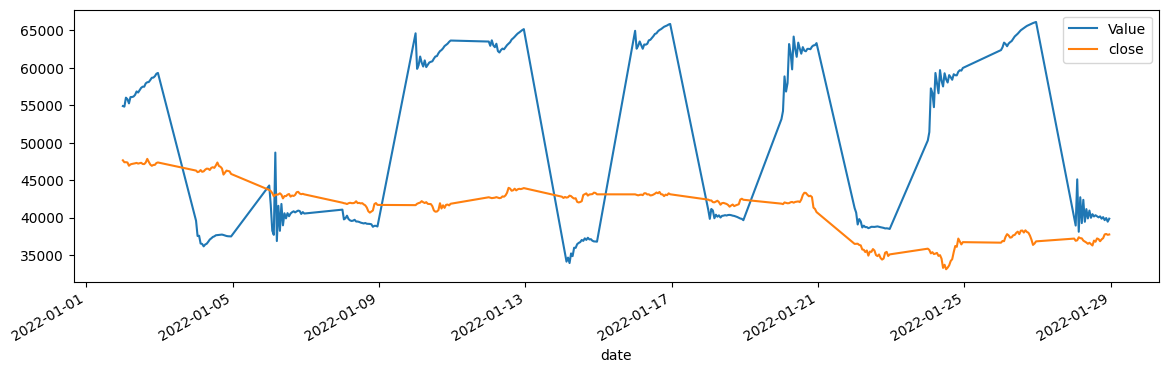

In [74]:
all_df = pd.concat(all_predicted_prices)
reserved_data['date'] = pd.to_datetime(reserved_data['date'])
all_df.rename(columns={'Date': 'date'}, inplace=True)
merged_df = pd.merge(all_df, reserved_data[['date', 'close']], on='date', how='left')
merged_df.head()
merged_df.set_index('date', inplace=True)
merged_df.plot()

In [75]:
print("Returns:")
print(returns)
print(len(returns))

Returns:
[0.013400546839232782, 0.02002657676407071, 0.06033163519493132, 0.04811775876439657, -0.0028370362113754382, 0.025611142350258666, -0.003442766873860349, 0.007210549737699939, 0.018214358324338323, -0.01692059582898011, 0.14500107432540923, -0.005597012268378316, 0.03106892181988636, -0.00897652226542631]
14


In [76]:
import math
rf = 0.0013
fees_per_transaction = 0.005 # TODO
sum_returns = sum(returns)

# sharpe ratio calculation
sharpe = (sum_returns - rf) / (np.std(np.array(returns)) * math.sqrt(28))
print(sharpe)

1.567492861673903


For period 2022 01 02 - 2022 01 30, 1.567 sharpe,
trades every 2 days to have more look back data for model





---




















### Evaluating 2021 02 with twitter sentiment

In [77]:
tweets_sentiment_1h = pd.read_csv("tweets_resampled_1h.csv")
tweets_sentiment_3h = pd.read_csv("tweets_resampled_3h.csv")
tweets_sentiment_1h['date'] = pd.to_datetime(tweets_sentiment_1h['date'])
tweets_sentiment_3h['date'] = pd.to_datetime(tweets_sentiment_3h['date'])

# tweets_sentiment = tweets_sentiment[tweets_sentiment['date'].dt.hour == 0]
# tweets_sentiment.head()
# decisions = tweets_sentiment['decision'].values

# try the data from 2022-02-06 to 2022-03-05
# convert date strings to datetime objects
start_date = pd.to_datetime('2021-02-06')
end_date = pd.to_datetime('2021-03-06')

# filter btc_hourly data for the specified date range and store in reserved_data2
reserved_data2 = btc_hourly[(pd.to_datetime(btc_hourly['date']) >= start_date) &
                            (pd.to_datetime(btc_hourly['date']) < end_date)]
reserved_data2.columns = reserved_data2.columns.str.lower()

returns = []
relevant_prices = []
type_of_trades = []
all_predicted_prices = []

actual_prices_in_range = []

# Convert 'date' column to datetime and extract the day
reserved_data2['day'] = pd.to_datetime(reserved_data2['date']).dt.date
reserved_data_group2 = reserved_data2.groupby(reserved_data2["day"])
reserved_data2['date']  = pd.to_datetime(reserved_data2['date'])

# Convert groupby object to a list of (name, group) tuples
groups = list(reserved_data_group2)


i = 0
group_iter = iter(groups)
for i, (name1, combined) in enumerate(group_iter):
    # Convert to tensors & run prediction
    x_tensors, y_tensors = data_to_tensor(combined, sequence_length=20)
    predicted_prices = predict_hourly(x_tensors, combined)

    # Calculate return
    first_date = combined['date'].min()
    last_date = combined['date'].max()

    # get actual returns for the matching period
    relevant_period = reserved_data2[(reserved_data2['date'] >= first_date) & (reserved_data2['date'] <= last_date)]
    all_predicted_prices.append(predicted_prices)
    actual_prices_in_range.append(relevant_period[["close", "date"]])

    # TODO HERE - THIS ACCOUNTS FOR TWITTER SENTIMENT
    detailed_hourly_decisions = tweets_sentiment_1h[(tweets_sentiment_1h['date'] >= first_date) & (tweets_sentiment_1h['date'] <= last_date)]['decision']
    initial_decision = tweets_sentiment_3h[(tweets_sentiment_3h['date'] >= first_date) & (tweets_sentiment_3h['date'] <= last_date)]['decision'].values[0]
    i += 1
    daily_ret, type_of_trade = daily_trade_return(predicted_prices["Value"], relevant_period["close"], sentiment_decision={"initial": initial_decision, "detailed": detailed_hourly_decisions.values})

    # code for no sentiment
    # daily_ret, type_of_trade = daily_trade_return(predicted_prices["Value"], relevant_period["close"], sentiment_decision=None)

    type_of_trades.append(type_of_trade)
    returns.append(daily_ret)



<ipython-input-77-d23ca9237293>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_data2['day'] = pd.to_datetime(reserved_data2['date']).dt.date
<ipython-input-77-d23ca9237293>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reserved_data2['date']  = pd.to_datetime(reserved_data2['date'])


predicting from this date: 2021-02-06 23:00:00
predicting from this date: 2021-02-07 23:00:00
predicting from this date: 2021-02-08 23:00:00
predicting from this date: 2021-02-09 23:00:00
predicting from this date: 2021-02-10 23:00:00
predicting from this date: 2021-02-11 23:00:00
predicting from this date: 2021-02-12 23:00:00
predicting from this date: 2021-02-13 23:00:00
predicting from this date: 2021-02-14 23:00:00
predicting from this date: 2021-02-15 23:00:00
predicting from this date: 2021-02-16 23:00:00
predicting from this date: 2021-02-17 23:00:00
predicting from this date: 2021-02-18 23:00:00
predicting from this date: 2021-02-19 23:00:00
predicting from this date: 2021-02-20 23:00:00
predicting from this date: 2021-02-21 23:00:00
predicting from this date: 2021-02-22 23:00:00
predicting from this date: 2021-02-23 23:00:00
predicting from this date: 2021-02-24 23:00:00
predicting from this date: 2021-02-25 23:00:00
predicting from this date: 2021-02-26 23:00:00
predicting fr

In [40]:
len(type_of_trades)
type_of_trades

['long',
 'dynamic: short whole day; start long at 17 and close long at 23',
 'long',
 'long',
 'dynamic: long whole day; start short at 8 and close short at 19',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'dynamic: long whole day; start short at 3 and close short at 11',
 'dynamic: long whole day; start short at 6 and close short at 16',
 'long',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'long',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'dynamic: long whole day; start short at 3 and close short at 9',
 'short',
 'short',
 'dynamic: long whole day; start short at 3 and close short at 23',
 'short',
 'dynamic: long whole day; start short at 

In [41]:
import pandas as pd

# Generate date range for the index
date_range = pd.date_range(start='2021-02-06', end='2021-03-05')
type_of_trades = type_of_trades[:len(date_range)]  # Adjust length if necessary
predicted_202102 = pd.DataFrame({'type_of_trades': type_of_trades}, index=date_range)

print(predicted_202102)
predicted_202102.to_pickle('./predicted_202102_longshort_no_sentiment_v3.pkl')


                                               type_of_trades
2021-02-06                                               long
2021-02-07  dynamic: short whole day; start long at 17 and...
2021-02-08                                               long
2021-02-09                                               long
2021-02-10  dynamic: long whole day; start short at 8 and ...
2021-02-11  dynamic: long whole day; start short at 3 and ...
2021-02-12  dynamic: long whole day; start short at 3 and ...
2021-02-13  dynamic: long whole day; start short at 3 and ...
2021-02-14  dynamic: long whole day; start short at 6 and ...
2021-02-15                                               long
2021-02-16  dynamic: long whole day; start short at 3 and ...
2021-02-17  dynamic: long whole day; start short at 3 and ...
2021-02-18  dynamic: long whole day; start short at 3 and ...
2021-02-19                                               long
2021-02-20  dynamic: long whole day; start short at 3 and ...
2021-02-

In [42]:
print(returns)

[0.01330772577722188, 0.019861502913057417, 0.19704015296544647, -0.006609968802625093, 0.0009430415784433127, 0.03150001899059621, -0.018831233783349454, 0.017778332702316237, 0.017597873200066082, -0.017770286885245908, 0.026086338273575045, 0.009957018064439029, -0.0026245926883967565, 0.08742784662096412, -0.00921932193835208, 0.003213850788771004, -0.026300650006100736, 0.07462869493553932, 0.008899569883828394, -0.00019726362634822636, 0.0010378324610065878, -0.006355646849639754, 0.02786527536108881, 0.0067616286002978865, -0.008901390886820515, -0.00253441600350204, -0.03723149159414552, -0.042381438722539806]


without sentiment based action

In [78]:
rf = 0.0007
# https://www.bankofcanada.ca/rates/interest-rates/t-bill-yields/
fees_per_transaction = 0.0002 # TODO
sum_returns = sum(returns)

# sharpe ratio calculation
sharpe = (sum_returns - rf) / (np.std(np.array(returns)) * math.sqrt(len(returns)))
print(sharpe)

1.3620666364636698


with sentiment action

In [43]:
rf = 0.0007
# https://www.bankofcanada.ca/rates/interest-rates/t-bill-yields/
fees_per_transaction = 0.0002 # TODO
sum_returns = sum(returns)

# sharpe ratio calculation
sharpe = (sum_returns - rf) / (np.std(np.array(returns)) * math.sqrt(len(returns)))
print(sharpe)

1.5396418952831166


### Results:

Sharpe without sentiment: 1.36
Sharpe with (no action if no aligned): 1.51
Sharpe with (action if no aligned): 1.54

In [ ]:
# torch.save(model.state_dict(), "./model_hourly_close2.pt")

In [ ]:
# torch.save(model.state_dict(), "./model_hourly_close_excludes202102.pt")